In [1]:
import h5py
import numpy as np
import os
import pod
import importlib
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
# set default font size
plt.rcParams['font.size'] = 10 # Change default font size to 12
plt.rcParams['axes.titlesize'] = 12 # Change axes title font size
plt.rcParams['axes.labelsize'] = 10 # Change axes labels font size
plt.rcParams['xtick.labelsize'] = 10 # Change x-axis tick labels font size
plt.rcParams['ytick.labelsize'] = 10 # Change y-axis tick labels font size
plt.rcParams['legend.fontsize'] = 10 # Change legend font size
plt.rcParams['figure.constrained_layout.use'] = True

paper_width = 470 # pt
width = paper_width / 72.27 # inches
height = width / 1.618 # inches

In [2]:
# reload pod
importlib.reload(pod)

<module 'pod' from '/home/HDD/cmorton/DLS_ML_Polishing/lib/pod.py'>

In [107]:
data_path = '../results/ldc_30k_60ksnaps/pod/latent_coeff.h5'
# data_path = '../results/ldc_15k/pod/latent_coeff.h5'
with h5py.File(data_path, 'r') as f:
    latent_coeff = f['dofs'][:2500, :200]
print(latent_coeff.shape)
latent_coeff = latent_coeff - np.mean(latent_coeff, axis=0)

(2500, 200)


In [108]:
extrap = pod.freq_extrapolation(latent_coeff[:-512], 0.01, 10000)

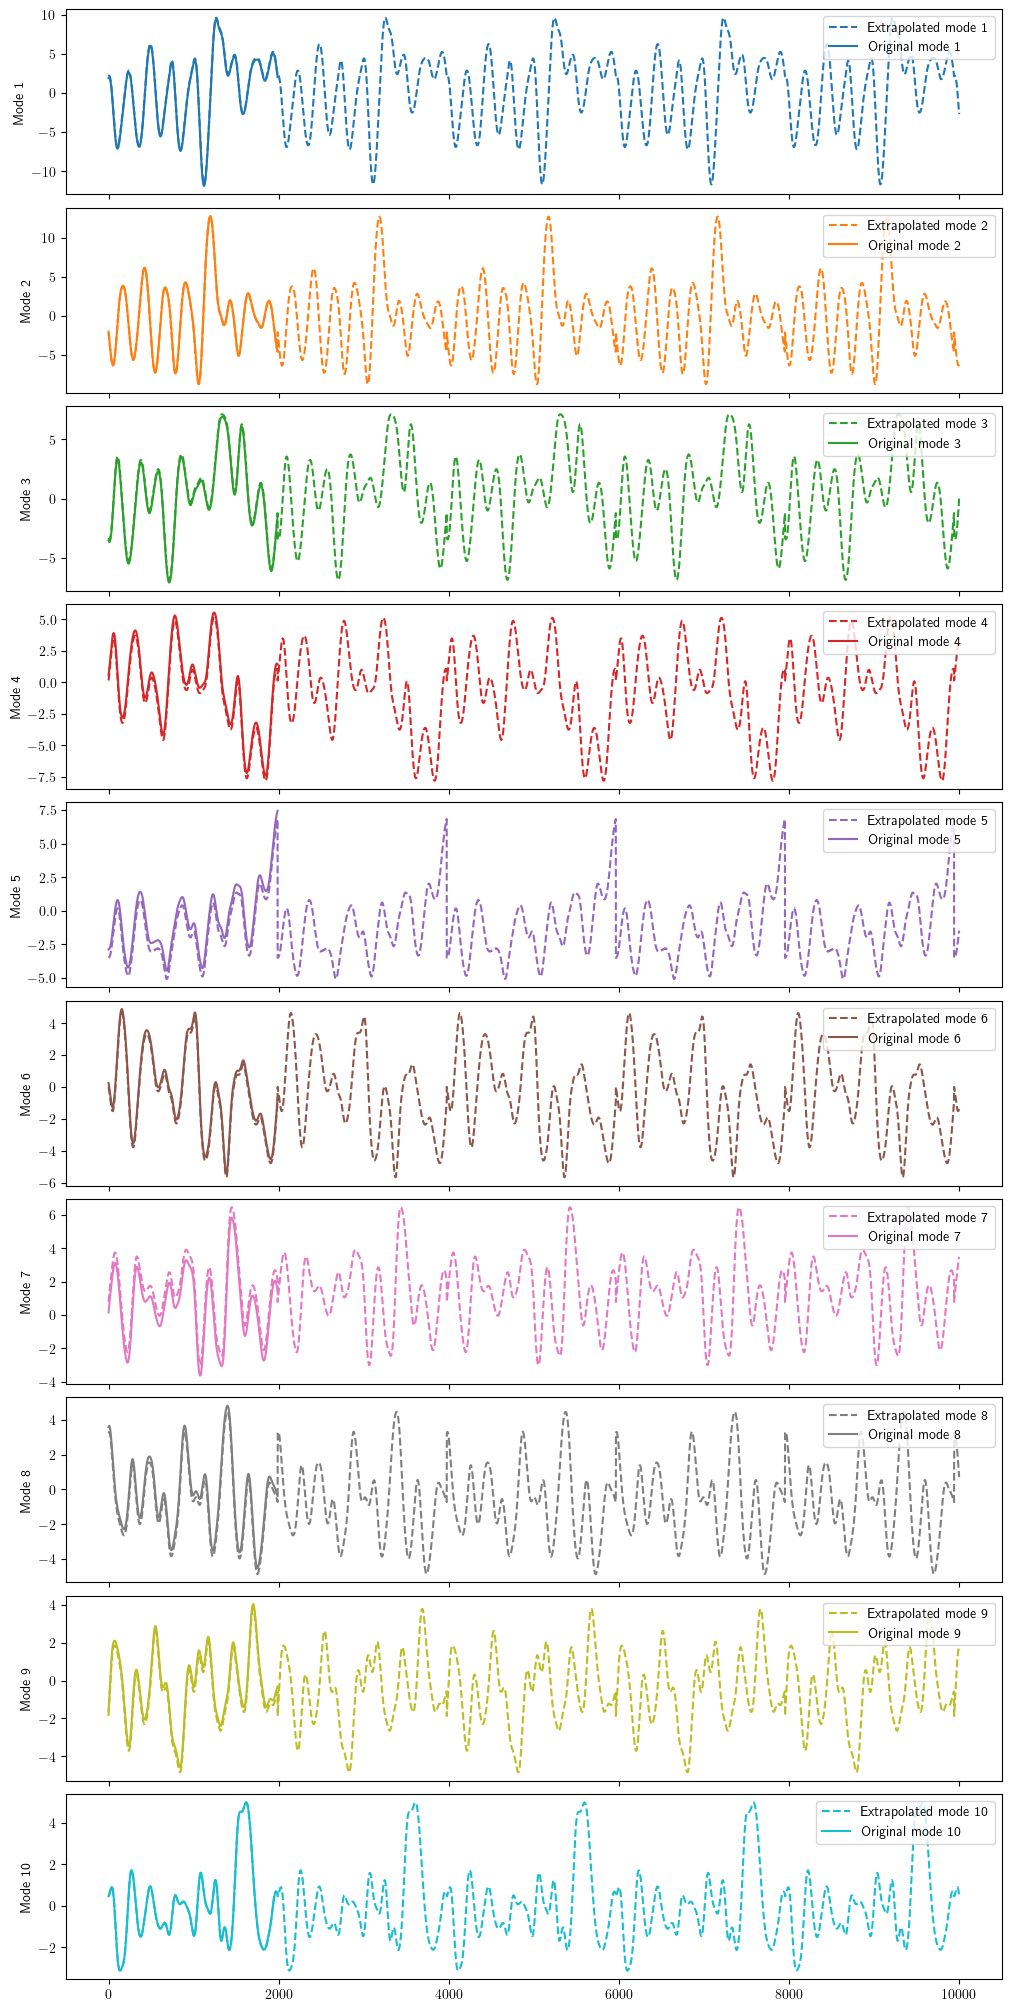

In [109]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(10, 1, figsize=(10, 20), sharex=True)
for i in range(10):
    color = f'C{i%10}'
    axes[i].plot(extrap[:, i].real, linestyle='--', color=color, label=f'Extrapolated mode {i+1}')
    axes[i].plot(latent_coeff[:-512, i], linestyle='-', color=color, label=f'Original mode {i+1}')
    axes[i].legend(loc='upper right')
    axes[i].set_ylabel(f'Mode {i+1}')
plt.savefig('freq_extrapolation.png')

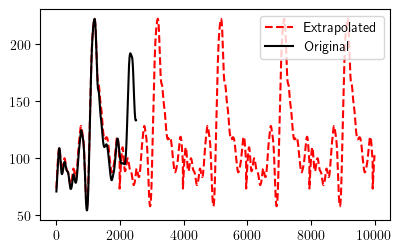

In [110]:
# plot sum(extrap**2, axis=1) vs sum(latent_coeff**2, axis=1)
size = 0.6
plt.figure(figsize=(size*width,size*height))
plt.plot(np.sum(extrap**2, axis=1), linestyle='--', label='Extrapolated',  color='r')
plt.plot(np.sum(latent_coeff**2, axis=1), label='Original', color = 'k')
plt.legend()

In [111]:
with h5py.File(data_path, 'r') as f:
    print(f['modes'].shape)
    modes = f['modes'][:, :200]

(524288, 1250)


In [112]:
Q_rec = np.dot(extrap[:, :], modes.T)
Q_rec = Q_rec.reshape(Q_rec.shape[0], 512, 512, 2)

In [113]:
RMS = np.sqrt(np.mean(Q_rec[-512:]**2, axis=0))

In [114]:
Q_path = '../data/ldc_15k.h5'
with h5py.File(Q_path, 'r') as f:
    mean = f['mean'][:]
    Q = f['UV'][:2500, :, :, :2]
    Q = Q - mean[np.newaxis,...]
RMS_true = np.sqrt(np.mean(Q[-512:]**2, axis=0))

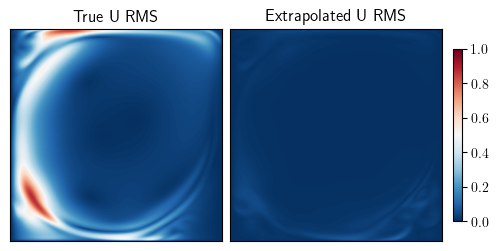

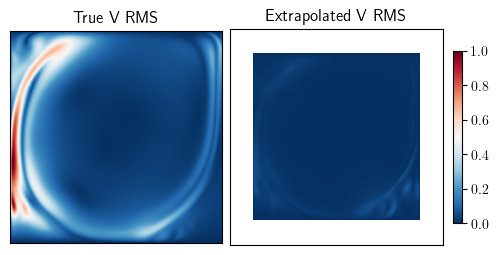

In [ ]:
size = 0.75

# plot RMS and RMS_true
RMS_true = RMS_true / np.max(RMS_true)
RMS = RMS / np.max(RMS_true)
plt.figure(figsize=(size*width,size*width/2))
plt.subplot(1, 2, 1)
plt.imshow(RMS_true[..., 0], vmin=0, vmax=1, origin='lower', cmap='RdBu_r')

plt.title('True U RMS')

plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
plt.imshow(RMS[..., 0], vmin=0, vmax=1, origin='lower', cmap='RdBu_r')
plt.title('Extrapolated U RMS')
plt.colorbar(shrink=0.8)
plt.xticks([])
plt.yticks([])
plt.savefig('RMS_comparison_U.png', dpi=600)
plt.figure(figsize=(size*width,size*width/2))
plt.subplot(1, 2, 1)
plt.imshow(RMS_true[..., 1], vmin=0, vmax=1, origin='lower', cmap='RdBu_r')

plt.title('True V RMS')
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
plt.imshow(RMS[..., 1], vmin=0, vmax=1, origin='lower', cmap='RdBu_r')
plt.colorbar(shrink=0.8)
plt.title('Extrapolated V RMS')
plt.xticks([])
plt.yticks([])
plt.axis('equal')
plt.savefig('RMS_comparison_V.png', dpi=600)
plt.show()

In [116]:
# RMS Error
error = np.linalg.norm(RMS - RMS_true) / np.linalg.norm(RMS_true)
print(f'RMS Error: {100*error:.4f}%')

RMS Error: 94.2646%


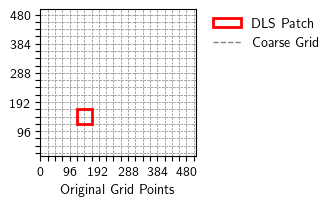

In [65]:
from matplotlib.lines import Line2D

# create a 512x512 grid with grid lines every 25 points
grid_size = 512
patch_size = 49
grid_skip = 24
grid_ticks = range(0, grid_size, grid_skip)

size = 0.3
fig = plt.figure(figsize=(size*width,size*width))
grid = plt.grid(which='both', color='gray', linestyle='--', linewidth=0.5)
plt.xlim(0, 511)
plt.ylim(0, 511)
plt.axis('equal')
# make grid but only show every 4th tick label
plt.xticks(grid_ticks)
plt.yticks(grid_ticks)
plt.gca().set_xticklabels([str(tick) if i % 4 == 0 else '' for i, tick in enumerate(grid_ticks)])
plt.gca().set_yticklabels([str(tick) if i % 4 == 0 else '' for i, tick in enumerate(grid_ticks)])

# create a box that appears like a square in the grid, centered on a grid point and spanning 3x3 grid points
# create Rectangle and add to current axes
rect = plt.Rectangle((grid_ticks[5], grid_ticks[5]),
                     patch_size, patch_size,
                     fill=False, edgecolor='red', linewidth=2, zorder=10)
plt.gca().add_patch(rect)

plt.xlabel('Original Grid Points')

# add rectangle and grid lines to legend
grid_line = Line2D([0], [0], color='gray', linestyle='--', linewidth=1)
fig.legend([rect, grid_line], ['DLS Patch', 'Coarse Grid'],
           loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
# plt.tight_layout(rect=[0, 0.01, 1, 1])

plt.savefig('grid_and_patch.png', dpi=600, bbox_inches='tight')
plt.show()